In [1]:
import sys

sys.path.remove('/usr/local/lib/python3.9/site-packages')
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [101]:
import os
import glob
import shutil
import random
import datetime
import csv
import colorsys
import math
import xlrd

import pandas as pd
import pickle
from PIL import Image, ExifTags, ImageDraw, ImageFont
import numpy as np
from itertools import chain
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

# Simple analysis

## Load collocated image

In [415]:
img = np.load('../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_1005.npy')

## Visualize

### Methods

In [3]:
def standarlize_image(img, div_param=2000):
    img = img / div_param
    img = np.where(img>1, 1, img)
    return img

def cal_ndvi(img_r, img_ir):
    return (img_ir - img_r) / (img_ir + img_r)

def trim_nan_margin(img):
    # trim row
    img_ = []
    for row in img:
        if not np.isnan(row).all():
            img_.append(row)
    img = np.array(img_)
    
    # trim_col
    img_ = []
    for col in img.T:
        if not np.isnan(col).all():
            img_.append(col)
    img = np.array(img_).T
    
    return img

### RGB

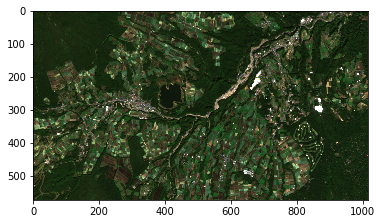

In [416]:
img_rgb = standarlize_image(np.array([img[4], img[3], img[2]]).transpose(1,2,0), div_param=2000)
plt.imshow(img_rgb)
# plt.axis('off')

### NDVI

In [188]:
img_ndvi = cal_ndvi(img[4], img[5])
img_ndvi = np.nan_to_num(img_ndvi)

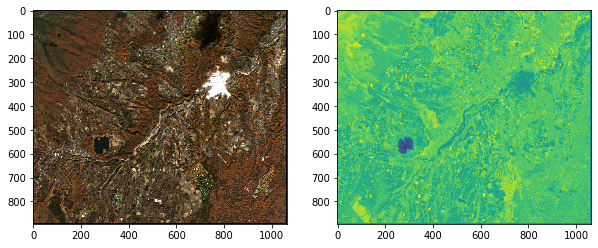

In [184]:
# 1110
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(img_ndvi)

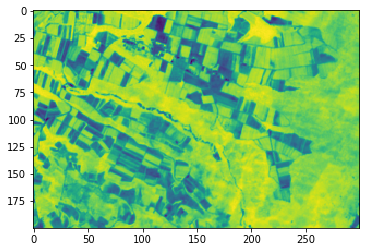

In [199]:
# 0808
plt.imshow(img_ndvi[300:500, 200: 500])

### SAR

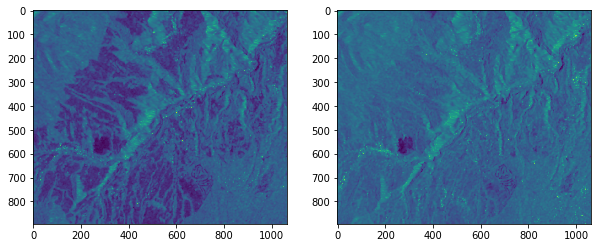

In [181]:
# 1110
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.imshow(img[1])

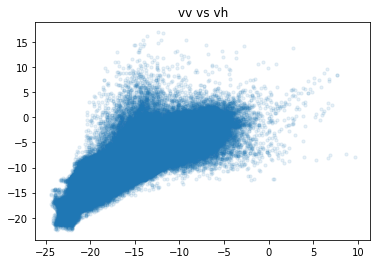

In [185]:
# 1110
plt.title('vv vs vh')
plt.scatter(img[0],img[1], s=10, alpha=0.1)

## Correlation analysis

### SAR vs NDVI

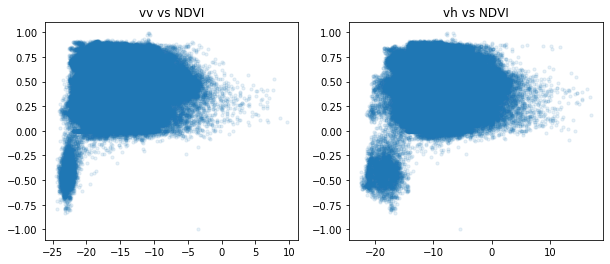

In [177]:
# 1110
# 後方散乱強くなるほど植生が多い傾向あり
# 中盤で後方散乱が多いのは何？ -> 位置出したら分かりそう
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('vv vs NDVI')
plt.scatter(img[0], img_ndvi, s=10, alpha=0.1)
plt.subplot(1,2,2)
plt.title('vh vs NDVI')
plt.scatter(img[1], img_ndvi, s=10, alpha=0.1)

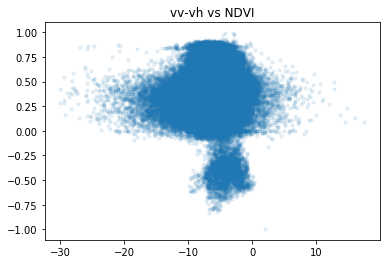

In [179]:
# 1110
plt.title('vv-vh vs NDVI')
plt.scatter(img[0] - img[1], img_ndvi, s=10, alpha=0.1)

# Data preprocessing

## Resize pixel number

In [7]:
# print raw pixel number
for path in glob.glob('../sar_2_ndvi/sentinel/kansas/bin/raw/*.npy'):
    img = np.load(path)
    print(img.shape)

(8, 3569, 7906)


In [6]:
def resize_array_3d(array_3d, h, w):
    img_list = []
    for img in array_3d:
        img_resized = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_LINEAR)
        img_list.append(img_resized)
    return np.array(img_list)

In [7]:
img_h = 1286 # 2193 # 573 # 1600
img_w = 1852 # 2554 # 1016 # 983
city = 'biei'

raw_bin_dir = f'../sar_2_ndvi/{city}/bin/raw/*.npy'

for path in glob.glob(raw_bin_dir):
    img = np.load(path)
    img_resized = resize_array_3d(img, img_h, img_w)
    np.save(path.replace('raw', 'pixel_resized'), img_resized)
    print(path)

../sar_2_ndvi/biei/bin/raw/collocate_19_0503.npy
../sar_2_ndvi/biei/bin/raw/collocate_19_0515.npy
../sar_2_ndvi/biei/bin/raw/collocate_0930.npy
../sar_2_ndvi/biei/bin/raw/collocate_19_1006.npy
../sar_2_ndvi/biei/bin/raw/collocate_19_0726.npy
../sar_2_ndvi/biei/bin/raw/collocate_0415.npy
../sar_2_ndvi/biei/bin/raw/collocate_0602.npy
../sar_2_ndvi/biei/bin/raw/collocate_19_0807.npy
../sar_2_ndvi/biei/bin/raw/collocate_19_cloud_0831.npy


# Heulistic prediction

## Load collocated image

In [70]:
'''
B1: VV
B2: VH
B3: B
B4: G
B5: R
B6: IR
B7: elevation
'''
img = np.load('../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0220.npy')
print(img.shape)

(8, 852, 1023)


## Data Preprocessing

### Masking

In [64]:
# If (sar_sum==0 or opt_sum==0) -> out of range
sar_mask = np.where(np.sum(img[0:2], axis=0)==0,0,1)
opt_mask = np.where(np.sum(img[2:], axis=0)==0,0,1)
valid_mask = sar_mask * opt_mask

# mask data
img = np.where(valid_mask==0, np.nan, img)

### Feature extraction

In [71]:
# Create sar and ndvi
img_ndvi = cal_ndvi(img[4], img[5])
# img_ndvi = np.nan_to_num(img_ndvi)

img_feature = np.array([img[0], img[1], img[6]])

print(img_ndvi.shape, img_feature.shape)

(852, 1023) (3, 852, 1023)


### Convert to input shape

In [72]:
h, v = img_ndvi.shape

# to split by location
train_test_flag_ = np.zeros((h, v))
train_test_flag_[h//2:, v//2:] = 1

train_test_flag = train_test_flag_.reshape(h*v)
y_ = img_ndvi.reshape(h*v)
X_ = img_feature.reshape(3, h*v).transpose(1,0)

# remove nan
train_test_flag = train_test_flag[~np.isnan(y_)]
y = y_[~np.isnan(y_)]
X = X_[~np.isnan(y_), :]
print(np.isnan(X).sum(), np.isnan(y).sum())

0 0


### Train test split

In [73]:
# split by random
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

# split by location
X_train = X[np.where(train_test_flag==0)]
X_test = X[np.where(train_test_flag==1)]
y_train = y[np.where(train_test_flag==0)]
y_test = y[np.where(train_test_flag==1)]

## Models

### Linear regression

In [74]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)
mse = mean_squared_error(pred, y_test)
mae = mean_absolute_error(pred, y_test)

print(f'mae: {mae}, mse: {mse}')
print('correlation coef: ', np.corrcoef(pred, y_test)[0][1])

mae: 0.11584194004535675, mse: 0.025075150653719902
correlation coef:  0.31955502281450016


In [75]:
# vhが高くてvvが低いほどNDVI高い -> 感覚と一致
model.coef_

array([ 0.0239209 , -0.01282031, -0.00035791], dtype=float32)

### Random forest

In [17]:
max_depth=2
n_estimators=5
criterion='mae'

In [ ]:
model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators, criterion=criterion)
model.fit(X_train, y_train)

pred = model.predict(X_test)
mse = mean_squared_error(pred, y_test)
mae = mean_absolute_error(pred, y_test)

print(f'mae: {mae}, mse: {mse}')
print('correlation coef: ', np.corrcoef(pred, y_test)[0][1])

## Validation

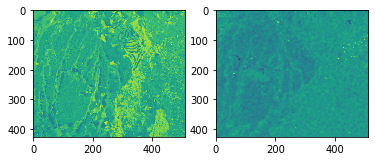

In [12]:
# show prediction
count = 0
pred_array = []
label_array = img_ndvi[h//2:, v//2:]

for row in label_array:
    pred_array_sub = []
    for elem in row:
        if np.isnan(elem):
            pred_array_sub.append(np.nan)
        else:
            pred_array_sub.append(pred[count])
            count += 1
    pred_array.append(pred_array_sub)
pred_array = np.array(pred_array)

plt.subplot(1,2,1)
plt.imshow(trim_nan_margin(img_ndvi[h//2:, v//2:]))
plt.subplot(1,2,2)
plt.imshow(trim_nan_margin(pred_array))

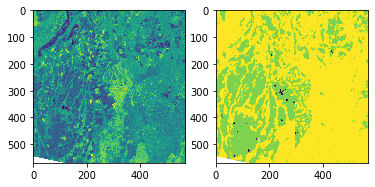

In [372]:
count = 0
pred_array = []
label_array = img_ndvi[h//2:, v//2:]

for row in label_array:
    pred_array_sub = []
    for elem in row:
        if np.isnan(elem):
            pred_array_sub.append(np.nan)
        else:
            pred_array_sub.append(pred[count])
            count += 1
    pred_array.append(pred_array_sub)
pred_array = np.array(pred_array)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(trim_nan_margin(img_ndvi[h//2:, v//2:]))
plt.subplot(1,2,2)
plt.imshow(trim_nan_margin(pred_array))

## Calculate in iteration

../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0220.npy
mae: 0.11584194004535675, mse: 0.025075150653719902
correlation coef:  0.31955502281450016
[ 0.0239209  -0.01282031 -0.00035791]


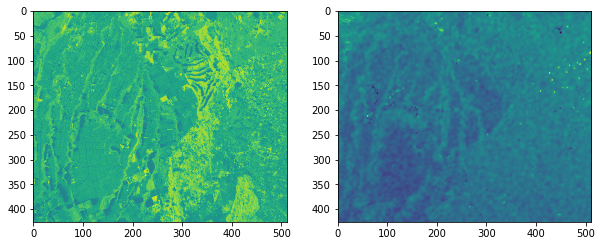

--------------------------------
../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0503.npy
mae: 0.09196001291275024, mse: 0.015322692692279816
correlation coef:  0.5904053390684371
[ 3.3242688e-02 -1.0273682e-02 -7.8852318e-05]


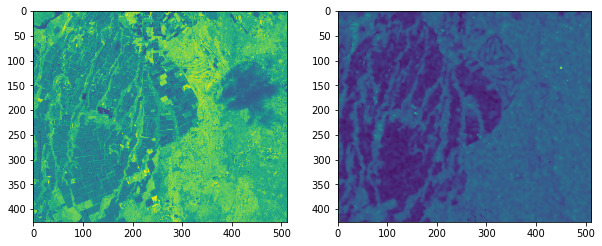

--------------------------------
../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0818.npy
mae: 0.14238183200359344, mse: 0.029220251366496086
correlation coef:  0.5805078062889036
[ 0.05312875 -0.00952415  0.0001699 ]


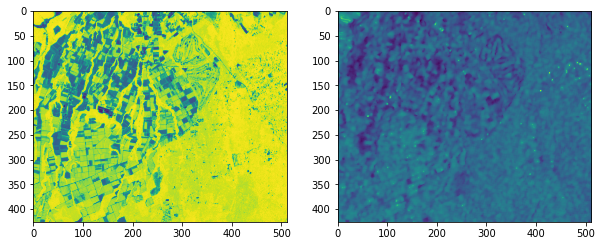

--------------------------------
../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_1110.npy
mae: 0.10012279450893402, mse: 0.01669050008058548
correlation coef:  0.4371823433111088
[ 0.02448918 -0.00721018  0.00015879]


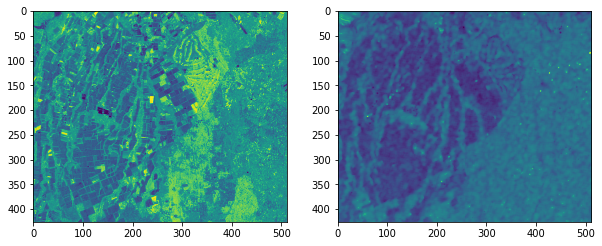

--------------------------------


In [47]:
file_paths = glob.glob('../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/*.npy')
file_paths.sort()

for path in file_paths:
    img = np.load(path)
    
    # If (sar_sum==0 or opt_sum==0) -> out of range
    sar_mask = np.where(np.sum(img[0:2], axis=0)==0,0,1)
    opt_mask = np.where(np.sum(img[2:], axis=0)==0,0,1)
    valid_mask = sar_mask * opt_mask

    # mask data
    img = np.where(valid_mask==0, np.nan, img)
    
    # Create sar and ndvi
    img_ndvi = cal_ndvi(img[4], img[5])
    img_feature = np.array([img[0], img[1], img[6]])

    h, v = img_ndvi.shape

    # to split by location
    train_test_flag_ = np.zeros((h, v))
    train_test_flag_[h//2:, v//2:] = 1

    train_test_flag = train_test_flag_.reshape(h*v)
    y_ = img_ndvi.reshape(h*v)
    X_ = img_feature.reshape(3, h*v).transpose(1,0)

    # remove nan
    train_test_flag = train_test_flag[~np.isnan(y_)]
    y = y_[~np.isnan(y_)]
    X = X_[~np.isnan(y_), :]
    
    # split by location
    X_train = X[np.where(train_test_flag==0)]
    X_test = X[np.where(train_test_flag==1)]
    y_train = y[np.where(train_test_flag==0)]
    y_test = y[np.where(train_test_flag==1)]
    
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    mae = mean_absolute_error(pred, y_test)
    
    print(path)
    print(f'mae: {mae}, mse: {mse}')
    print('correlation coef: ', np.corrcoef(pred, y_test)[0][1])
    print(model.coef_)
    
    count = 0
    pred_array = []
    label_array = img_ndvi[h//2:, v//2:]

    for row in label_array:
        pred_array_sub = []
        for elem in row:
            if np.isnan(elem):
                pred_array_sub.append(np.nan)
            else:
                pred_array_sub.append(pred[count])
                count += 1
        pred_array.append(pred_array_sub)
    pred_array = np.array(pred_array)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(trim_nan_margin(img_ndvi[h//2:, v//2:]))
    plt.subplot(1,2,2)
    plt.imshow(trim_nan_margin(pred_array))
    plt.show()

    print('--------------------------------')

../sar_2_ndvi/sentinel/otofuke/bin/pixel_resized/collocate_crop_0329.npy
mae: 0.08173529803752899, mse: 0.011808331124484539
correlation coef:  0.17610934158297792
[-2.6274158e-04 -4.1565965e-03 -8.6094151e-05]


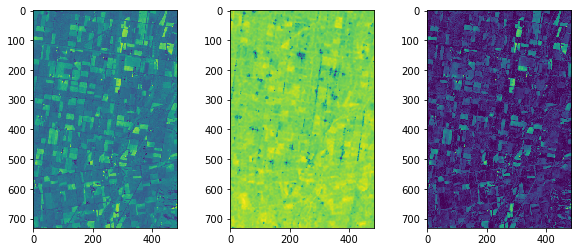

--------------------------------
../sar_2_ndvi/sentinel/otofuke/bin/pixel_resized/collocate_crop_0524.npy
mae: 0.1687617301940918, mse: 0.0403335876762867
correlation coef:  0.6872431035192568
[ 8.552954e-02 -6.952628e-02 -2.928125e-05]


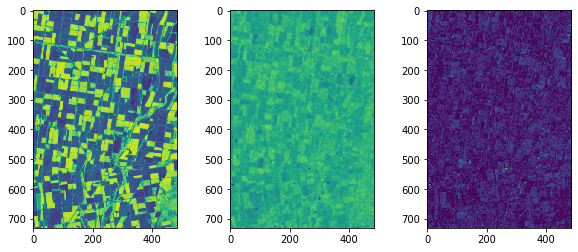

--------------------------------
../sar_2_ndvi/sentinel/otofuke/bin/pixel_resized/collocate_crop_0820.npy
mae: 0.21765175461769104, mse: 0.06391159445047379
correlation coef:  0.39064234268200054
[ 0.07917046 -0.02944482  0.00109108]


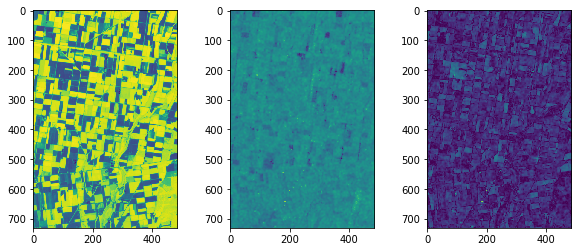

--------------------------------
../sar_2_ndvi/sentinel/otofuke/bin/pixel_resized/collocate_crop_1108.npy
mae: 0.1398075520992279, mse: 0.028756653890013695
correlation coef:  0.37975205883109514
[ 0.0355104  -0.04601029  0.00019436]


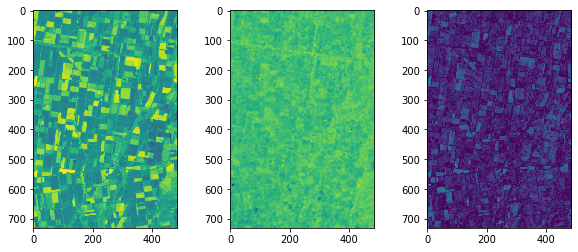

--------------------------------


In [23]:
file_paths = glob.glob('../sar_2_ndvi/sentinel/otofuke/bin/pixel_resized/*.npy')
file_paths.sort()

for path in file_paths:
    img = np.load(path)
    
    # If (sar_sum==0 or opt_sum==0) -> out of range
    sar_mask = np.where(np.sum(img[0:2], axis=0)==0,0,1)
    opt_mask = np.where(np.sum(img[2:], axis=0)==0,0,1)
    valid_mask = sar_mask * opt_mask

    # mask data
    img = np.where(valid_mask==0, np.nan, img)
    
    # Create sar and ndvi
    img_ndvi = cal_ndvi(img[4], img[5])
    img_feature = np.array([img[0], img[1], img[6]])

    h, v = img_ndvi.shape

    # to split by location
    train_test_flag_ = np.zeros((h, v))
    train_test_flag_[h//2:, v//2:] = 1

    train_test_flag = train_test_flag_.reshape(h*v)
    y_ = img_ndvi.reshape(h*v)
    X_ = img_feature.reshape(3, h*v).transpose(1,0)

    # remove nan
    train_test_flag = train_test_flag[~np.isnan(y_)]
    y = y_[~np.isnan(y_)]
    X = X_[~np.isnan(y_), :]
    
    # split by location
    X_train = X[np.where(train_test_flag==0)]
    X_test = X[np.where(train_test_flag==1)]
    y_train = y[np.where(train_test_flag==0)]
    y_test = y[np.where(train_test_flag==1)]
    
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    mae = mean_absolute_error(pred, y_test)
    
    print(path)
    print(f'mae: {mae}, mse: {mse}')
    print('correlation coef: ', np.corrcoef(pred, y_test)[0][1])
    print(model.coef_)
    
    count = 0
    pred_array = []
    label_array = img_ndvi[h//2:, v//2:]

    for row in label_array:
        pred_array_sub = []
        for elem in row:
            if np.isnan(elem):
                pred_array_sub.append(np.nan)
            else:
                pred_array_sub.append(pred[count])
                count += 1
        pred_array.append(pred_array_sub)
    pred_array = np.array(pred_array)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(trim_nan_margin(img_ndvi[h//2:, v//2:]))
    plt.subplot(1,3,2)
    plt.imshow(trim_nan_margin(pred_array))
    plt.subplot(1,3,3)
    plt.imshow(np.abs(trim_nan_margin(img_ndvi[h//2:, v//2:]) - trim_nan_margin(pred_array)))
    plt.show()

    print('--------------------------------')

../sar_2_ndvi/sentinel/niigata/bin/pixel_resized/collocate_crop_0328.npy
mae: 0.09705211222171783, mse: 0.022005736827850342
correlation coef:  -0.10223539848130024
[-0.00366087 -0.00736258  0.00405854]


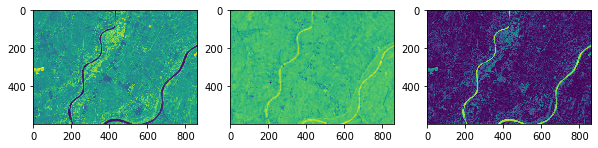

--------------------------------
../sar_2_ndvi/sentinel/niigata/bin/pixel_resized/collocate_crop_0502.npy
mae: 0.11832127720117569, mse: 0.0263541117310524
correlation coef:  0.42367818428143594
[0.01229548 0.00051047 0.00877901]


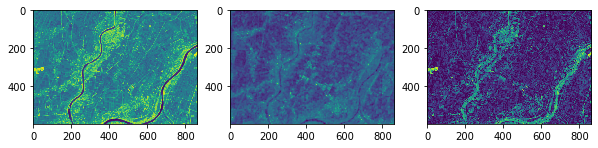

--------------------------------
../sar_2_ndvi/sentinel/niigata/bin/pixel_resized/collocate_crop_0807.npy
mae: 0.17675669491291046, mse: 0.05706580728292465
correlation coef:  0.2709139456960082
[-0.01603661 -0.02882022 -0.00164663]


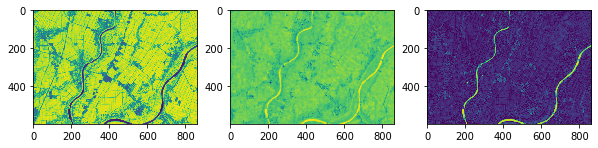

--------------------------------
../sar_2_ndvi/sentinel/niigata/bin/pixel_resized/collocate_crop_1117.npy
mae: 0.11871756613254547, mse: 0.02779814600944519
correlation coef:  -0.03182621026407956
[-0.0004956  -0.0070863   0.00709224]


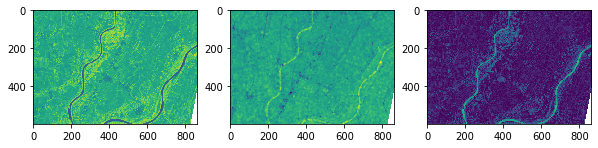

--------------------------------


In [42]:
file_paths = glob.glob('../sar_2_ndvi/sentinel/niigata/bin/pixel_resized/*.npy')
file_paths.sort()

for path in file_paths:
    img = np.load(path)
    
    # If (sar_sum==0 or opt_sum==0) -> out of range
    sar_mask = np.where(np.sum(img[0:2], axis=0)==0,0,1)
    opt_mask = np.where(np.sum(img[2:], axis=0)==0,0,1)
    valid_mask = sar_mask * opt_mask

    # mask data
    img = np.where(valid_mask==0, np.nan, img)
    
    # Create sar and ndvi
    img_ndvi = cal_ndvi(img[4], img[5])
    img_feature = np.array([img[0], img[1], img[6]])

    h, v = img_ndvi.shape

    # to split by location
    train_test_flag_ = np.zeros((h, v))
    train_test_flag_[h//2:, v//2:] = 1

    train_test_flag = train_test_flag_.reshape(h*v)
    y_ = img_ndvi.reshape(h*v)
    X_ = img_feature.reshape(3, h*v).transpose(1,0)

    # remove nan
    train_test_flag = train_test_flag[~np.isnan(y_)]
    y = y_[~np.isnan(y_)]
    X = X_[~np.isnan(y_), :]
    
    # split by location
    X_train = X[np.where(train_test_flag==0)]
    X_test = X[np.where(train_test_flag==1)]
    y_train = y[np.where(train_test_flag==0)]
    y_test = y[np.where(train_test_flag==1)]
    
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    mae = mean_absolute_error(pred, y_test)
    
    print(path)
    print(f'mae: {mae}, mse: {mse}')
    print('correlation coef: ', np.corrcoef(pred, y_test)[0][1])
    print(model.coef_)
    
    count = 0
    pred_array = []
    label_array = img_ndvi[h//2:, v//2:]

    for row in label_array:
        pred_array_sub = []
        for elem in row:
            if np.isnan(elem):
                pred_array_sub.append(np.nan)
            else:
                pred_array_sub.append(pred[count])
                count += 1
        pred_array.append(pred_array_sub)
    pred_array = np.array(pred_array)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(trim_nan_margin(img_ndvi[h//2:, v//2:]))
    plt.subplot(1,3,2)
    plt.imshow(trim_nan_margin(pred_array))
    plt.subplot(1,3,3)
    plt.imshow(np.abs(trim_nan_margin(img_ndvi[h//2:, v//2:]) - trim_nan_margin(pred_array)))
    plt.show()

    print('--------------------------------')

# Cloud percentage bar graph

In [23]:
''' # In Google Earth Engine
var ROI = Map.getBounds(true)

var sentinel2 = ee.ImageCollection("COPERNICUS/S2")
.filterBounds(ROI)
.filterDate('2020-01-01','2020-12-10')

var chart = ui.Chart.feature.byFeature({
    features: sentinel2, 
    yProperties: ['CLOUD_COVERAGE_ASSESSMENT']
  })
  .setChartType('ScatterChart')
  .setOptions({
    title: 'Cloud cover percentage',
    hAxis: {title: 'Date'},
    vAxis: {title: 'Clouds'},
    // lineWidth: 1,
    pointSize: 1
  })

print(chart)'''

' # In Google Earth Engine\nvar ROI = Map.getBounds(true)\n\nvar sentinel2 = ee.ImageCollection("COPERNICUS/S2")\n.filterBounds(ROI)\n.filterDate(\'2020-01-01\',\'2020-12-10\')\n\nvar chart = ui.Chart.feature.byFeature({\n    features: sentinel2, \n    yProperties: [\'CLOUD_COVERAGE_ASSESSMENT\']\n  })\n  .setChartType(\'ScatterChart\')\n  .setOptions({\n    title: \'Cloud cover percentage\',\n    hAxis: {title: \'Date\'},\n    vAxis: {title: \'Clouds\'},\n    // lineWidth: 1,\n    pointSize: 1\n  })\n\nprint(chart)'

In [35]:
df = pd.read_csv('/Users/ryotanomura/Downloads/ee-chart.csv')
df = df.rename(columns={'system:index': 'name', 'CLOUD_COVERAGE_ASSESSMENT': 'cloud_per'})
df.head()

name  cloud_per
0  COPERNICUS/S2/20200101T014049_20200101T014048_...     76.757
1  COPERNICUS/S2/20200101T014049_20200101T014048_...     88.530
2  COPERNICUS/S2/20200101T014049_20200101T014048_...     94.995
3  COPERNICUS/S2/20200101T014049_20200101T014048_...     87.379
4  COPERNICUS/S2/20200101T014049_20200101T014048_...     80.782

In [123]:
# dataframeの加工
date_list = []
type_list = []

for index, row in df.iterrows():
    name = str(row['name'])
    data_type = name[-3:]
    date_str = name[14:22]
    date = datetime.datetime.strptime(date_str, '%Y%m%d')
    
    date_list.append(date)
    type_list.append(data_type)
    
df['type'] = np.array(type_list)
df['date'] = np.array(date_list)

df = df[df['type']=='TXN'].reset_index(drop=True)

In [124]:
# 日付の差分から抽出
prev_month = 13
start_dates = [datetime.datetime(2020,12,8), datetime.datetime(2020,12,5)]
df_extracted = pd.DataFrame()

for date in start_dates:
    print(date)
    while date >= datetime.datetime(2020,1,1):
        row = df[df['date']==date]
        if len(row) >= 1:
            df_extracted = df_extracted.append(row.iloc[0])
        date -= datetime.timedelta(days=10)
        
df_extracted = df_extracted.sort_values('date').reset_index(drop=True)
df_extracted['available_area'] = 100 - df_extracted['cloud_per']

2020-12-08 00:00:00
2020-12-05 00:00:00


In [134]:
# ラベル用の日付
date_str_list = []
prev_month = 13

for index, row in df_extracted.iterrows():
    name = str(row['name'])
    date_str = name[14:22]
    date = datetime.datetime.strptime(date_str, '%Y%m%d')
    if date.month != prev_month:
        date_str_list.append(date_str[4:6]+'-'+date_str[6:])
        prev_month = date.month
    else:
        date_str_list.append('')
        
df_extracted['date_str'] = np.array(date_str_list)

Text(0, 0.5, 'percentage of observable area')

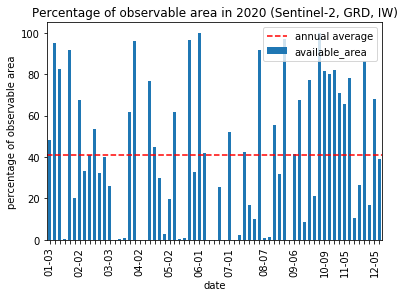

In [140]:
ax = df_extracted.plot.bar(x='date_str', y='available_area', title='Percentage of observable area in 2020 (Sentinel-2, GRD, IW)')
ax.axhline(y=df_extracted['available_area'].mean(), label='annual average', linestyle='--', color='red')
ax.legend()
ax.set_xlabel('date')
ax.set_ylabel('percentage of observable area')

# Data usage bar graph

In [40]:
city = 'oushu'

# idx_s1_list = ['19_0108','19_0120','19_0213','19_0309','19_0414','19_0508','19_0812','19_0917','19_0929','19_1023','19_1210','0127','0303','0327','0420','0502','0818','1005','1110','1204'] # tsumagoi
# idx_s2_list = ['19_0108','19_0118','19_0217','19_0309','19_0418','19_0508','19_0809','19_0915','19_0925','19_1028','19_1214','0126','0303','0326','0425','0502','0820','1002','1108','1201'] # tsumagoi
# idx_s1_list = ['19_0424','19_0506','19_0729','19_1102','0325','0524','0605','0804','0816','0828','1015','1027','1108','1120'] # otofuke
# idx_s2_list = ['19_0428','19_0505','19_0803','19_1104','0330','0522','0601','0731','0817','0827','1009','1026','1108','1125'] # otofuke
# idx_s1_list = ['19_0415','19_0509','19_0708','19_0906','0328','0421','0503','0608','0620','0807','0924','1123'] # niigata
# idx_s2_list = ['19_0418','19_0508','19_0710','19_0908','0326','0425','0502','0604','0621','0810','0929','1118'] # niigata
idx_s1_list = ['19_0421','19_0503','19_0620','19_0807','19_0924','19_1217','0310','0626','0825','0906'] # oushu
idx_s2_list = ['19_0418','19_0508','19_0617','19_0806','19_0925','19_1214','0313','0621','0820','0909'] # oushu

max_h = 0
max_w = 0
s2_area_array = []
s1_date_array = []
s2_date_array = []

for idx_s2, idx_s1 in zip(idx_s2_list, idx_s1_list):
    if os.path.exists(f'../sar_2_ndvi/{city}/bin/pixel_resized/collocate_{idx_s1}.npy'):
        img = np.load(f'../sar_2_ndvi/{city}/bin/pixel_resized/collocate_{idx_s1}.npy')
    else:
        img = np.load(f'../sar_2_ndvi/{city}/bin/pixel_resized/collocate_cloud_{idx_s1}.npy')
    c, h, w = img.shape
    max_h = max(max_h, h)
    max_w = max(max_w, w)
    s2_area_array.append(h*w)
    if '19_' in idx_s1:
        idx_s1 = idx_s1.replace('19_', '')
        idx_s2 = idx_s2.replace('19_', '')
        s1_date_array.append(datetime.datetime.strptime('2019'+idx_s1, '%Y%m%d'))
        s2_date_array.append(datetime.datetime.strptime('2019'+idx_s2, '%Y%m%d'))
    else:
        s1_date_array.append(datetime.datetime.strptime('2020'+idx_s1, '%Y%m%d'))
        s2_date_array.append(datetime.datetime.strptime('2020'+idx_s2, '%Y%m%d'))

s2_area_array = np.array(s2_area_array) / (max_h*max_w)

Text(0.5, 0, 'date')

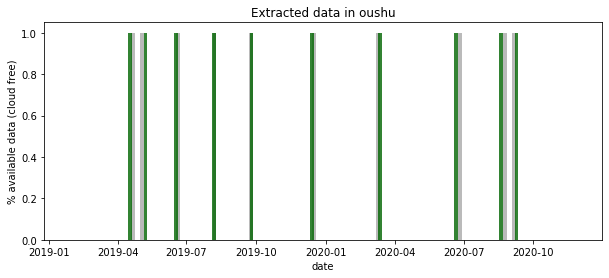

In [41]:
plt.figure(figsize=(10,4))
plt.bar(s1_date_array, np.array([1 for _ in range(len(s1_date_array))]), width=5, color='darkgrey', alpha=0.8, label='Sentinel-1')
plt.bar(s2_date_array, s2_area_array, width=5, color='darkgreen', alpha=0.8, label='Sentinel-2')
# mod_list = [datetime.datetime(2020,1,26),datetime.datetime(2020,3,3),datetime.datetime(2020,4,25),datetime.datetime(2020,5,2),datetime.datetime(2020,8,20),datetime.datetime(2020,10,2),datetime.datetime(2020,11,8),datetime.datetime(2020,12,1)]
# plt.scatter(mod_list, [1.05 for _ in range(len(mod_list))], color='salmon', label='Modis', marker='^')
# plt.xticks(rotation=45)
plt.xlim(datetime.datetime(2018, 12, 25, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))
plt.title(f'Extracted data in {city}')
plt.ylabel('% available data (cloud free)')
plt.xlabel('date')
# plt.legend()

# NDVI histogram

In [73]:
idx = '0818'
img_sen = np.load(f'../sar_2_ndvi/tsumagoi/bin/patch_sr/125/pred_img/sen_{idx}.npy')
img_pred = np.load(f'../sar_2_ndvi/tsumagoi/bin/patch_sr/125/pred_img/pred_{idx}.npy')
img_sen_ = drop_resolution(img_sen)

(-1, 1)

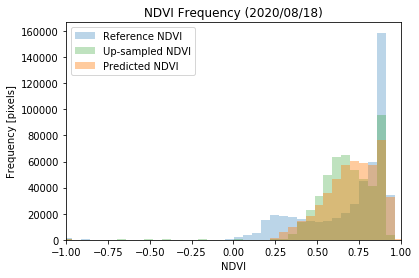

In [74]:
_img_sen = np.ravel(img_sen)
_img_pred = np.ravel(img_pred)
_img_sen_ = np.ravel(img_sen_)

bins=np.histogram(np.hstack((img_sen,img_pred)), bins=40)[1] #get the bin edges
plt.hist(_img_sen, bins, alpha=0.3, label='Reference NDVI')
plt.hist(_img_sen_, bins, alpha=0.3, label='Up-sampled NDVI', color='C2')
plt.hist(_img_pred, bins, alpha=0.4, label='Predicted NDVI', color='C1')
plt.title('NDVI Frequency (2020/08/18)')
plt.xlabel('NDVI')
plt.ylabel('Frequency [pixels]')
plt.legend(loc='upper left')
plt.xlim(-1, 1)

Text(0.5, 1.0, 'Reference NDVI (Sentinel-2)')

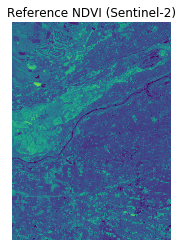

In [58]:
plt.imshow(img_sen, vmin=0, vmax=1)
plt.axis('off')
plt.title('Reference NDVI (Sentinel-2)')

Text(0.5, 1.0, 'Up-sampled NDVI')

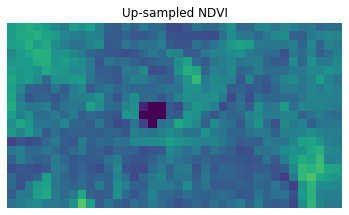

In [68]:
plt.imshow(img_sen_, vmin=0, vmax=1)
plt.axis('off')
plt.title('Up-sampled NDVI')

Text(0.5, 1.0, 'Predicted NDVI')

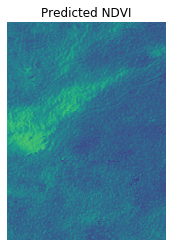

In [59]:
plt.imshow(img_pred, vmin=0, vmax=1)
plt.axis('off')
plt.title('Predicted NDVI')
# plt.colorbar()

# Modis-Sentinel error plot

In [64]:
np.array([0.097,
0.129,
0.092,
0.109
]) - np.array([0.059,
0.117,
0.092,
0.081,
])

array([0.038, 0.012, 0.   , 0.028])

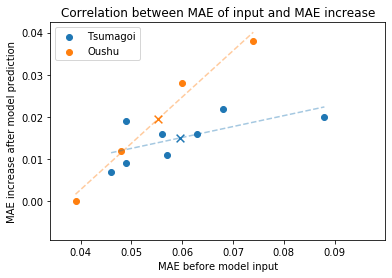

In [73]:
input_error_list = [[0.068,0.056,0.049,0.057,0.088,0.063,0.046,0.049],[0.074,0.048,0.039,0.060]]
output_error_list = [[0.022, 0.016, 0.019, 0.011, 0.02 , 0.016, 0.007, 0.009],[0.038, 0.012, 0.   , 0.028]]

for input_error, output_error, area, color in zip(input_error_list, output_error_list, ['Tsumagoi', 'Oushu'], ['C0', 'C1']):
    plt.scatter(input_error, output_error, label=area)

    s = np.polyfit(input_error, output_error, 1)
    func = np.poly1d(s)
    y = func(input_error)
    plt.plot(sorted(input_error), sorted(y), linestyle='--', alpha=0.4, color=color)
    
    plt.scatter(np.mean(input_error), np.mean(output_error), marker='x', color=color, s=60)

plt.title('Correlation between MAE of input and MAE increase')
plt.ylabel('MAE increase after model prediction')
plt.xlabel('MAE before model input')
plt.legend(loc='upper left')

# Show Modis difference

In [12]:
def drop_resolution(img_1ch, scale=25):
    h, w = img_1ch.shape
    h_, w_ = h//scale, w//scale
    img_small = np.zeros((h_, w_))
    
    for i in range(h_):
        for j in range(w_):
            img_small[i, j] = np.mean(img_1ch[i*scale:(i+1)*scale, j*scale:(j+1)*scale])
            
    img_resized = img_small.repeat(scale, axis=0).repeat(scale, axis=1)
    return img_resized

In [381]:
mod_ndvi = drop_resolution(np.load('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/tsumagoi/modis/bin/pixel_resized/collocate_mod_1005.npy')[0,:,:])
sen_img = np.load('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_1005.npy')
sen_ndvi = drop_resolution(cal_ndvi(sen_img[4], sen_img[5]))

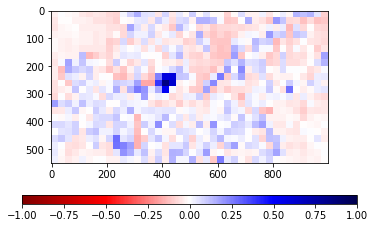

In [388]:
plt.imshow(mod_ndvi - sen_ndvi, cmap='seismic_r', vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal', aspect=40)

# Show data acquired date

In [341]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + datetime.timedelta(n)

start_date = datetime.date(2020,1,1)
end_date = datetime.date(2020,12,31)

date_str_list = []
date_list = []
for dt in daterange(start_date, end_date):
    date_str_list.append(dt.strftime("%m-%d"))
    date_list.append(dt)

In [152]:
s1_dict = {'12-04':1, '12-11':1, '12-16':1, '12-23':1, '12-28':1}
s2_dict = {'12-01':0.78, '12-08':0.38, '12-11':0.41, '12-18':0.90, '12-21':0.66, '12-28':0.76, '12-31':0.25}

s1_list = []
s2_list = []
for i, date_str in enumerate(date_str_list):
    if date_str in s1_dict:
        s1_list.append(s1_dict[date_str])
    else:
        s1_list.append(0)
    if date_str in s2_dict:
        s2_list.append(s2_dict[date_str])
    else:
        s2_list.append(0)

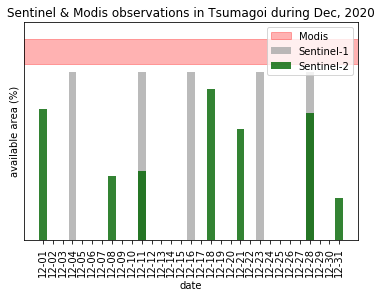

In [156]:
fig, ax = plt.subplots()

ax.bar(date_str_list, s1_list, label='Sentinel-1', color='darkgrey', alpha=0.8)
ax.bar(date_str_list, s2_list, label='Sentinel-2', color='darkgreen', alpha=0.8)

ax.axhspan(ymin=1.05, ymax=1.2, xmin=0, xmax=1, color='red', alpha=0.3, label='Modis')

ax.set_title('Sentinel & Modis observations in Tsumagoi during Dec, 2020')
ax.set_xlabel('date')
ax.set_ylabel('available area (%)')
ticks = plt.xticks(rotation=90)
plt.ylim(0,1.3)
ax = plt.gca()
ax.axes.yaxis.set_ticks([])

plt.legend()

In [343]:
s1_dict = {'01-03':1, '01-15':1, '01-27':1, '02-20':1, '03-03':1, '03-15':1, '04-08':1, '04-20':1, '05-02':1, '05-14':1, '06-07':1, '06-19':1, '08-18':1, '10-05':1, '10-29':1, '11-10':1, '11-22':1, '12-04':1, '12-16':1}
s2_dict = {'01-26':1, '03-03':1, '03-06':1, '03-23':1, '03-26':1, '04-15':1, '04-25':1, '05-02':1, '05-05':1, '08-20':1, '10-02':1, '11-08':1, '12-01':1}

s1_list = []
s2_list = []
for i, date_str in enumerate(date_str_list):
    if date_str in s1_dict:
        s1_list.append(s1_dict[date_str])
    else:
        s1_list.append(0)
    if date_str in s2_dict:
        s2_list.append(s2_dict[date_str])
    else:
        s2_list.append(0)

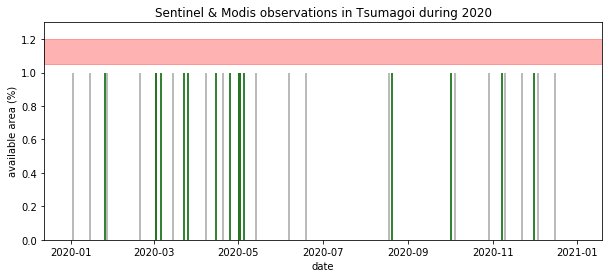

In [344]:
fig, ax = plt.subplots(figsize=(10,4))

ax.bar(date_list, s1_list, label='Sentinel-1', color='darkgrey', alpha=0.8, width=1.5)
ax.bar(date_list, s2_list, label='Sentinel-2', color='darkgreen', alpha=0.8, width=1.5)

ax.axhspan(ymin=1.05, ymax=1.2, xmin=0, xmax=1, color='red', alpha=0.3, label='Modis')

ax.set_title('Sentinel & Modis observations in Tsumagoi during 2020')
ax.set_xlabel('date')
ax.set_ylabel('available area (%)')
# ticks = plt.xticks(rotation=90)
plt.ylim(0,1.3)
ax = plt.gca()
# ax.axes.yaxis.set_ticks([])

# plt.legend()

In [ ]:
terra_list = sorted(glob.glob('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/tsumagoi/time_series/terra_year/bin/*.npy'))
aqua_list = sorted(glob.glob('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/tsumagoi/time_series/aqua_year/bin/*.npy'))

date_str_list = []

for path in terra_list:
    date_str_list.append(path[-8:-4])
    
for path in aqua_list:
    date_str_list.append(path[-8:-4])
    
date_str_list = list(set(date_str_list))
mod_date_list = [datetime.datetime.strptime('2020'+date_str, '%Y%m%d') for date_str in date_str_list]

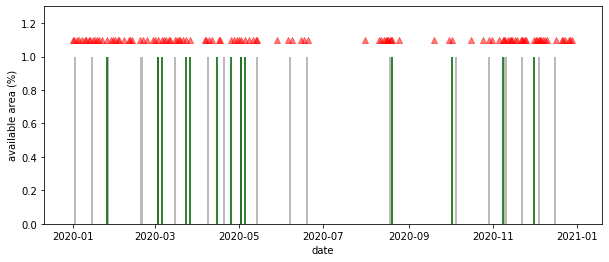

In [352]:
fig, ax = plt.subplots(figsize=(10,4))

ax.bar(date_list, s1_list, label='Sentinel-1', color='darkgrey', alpha=0.8, width=1.5)
ax.bar(date_list, s2_list, label='Sentinel-2', color='darkgreen', alpha=0.8, width=1.5)

# ax.axhspan(ymin=1.05, ymax=1.2, xmin=0, xmax=1, color='red', alpha=0.3, label='Modis')
ax.scatter(mod_date_list, [1.1 for _ in range(len(mod_date_list))], color='red', marker='^', alpha=0.5)

# ax.set_title('Sentinel & Modis observations in Tsumagoi during 2020')
ax.set_xlabel('date')
ax.set_ylabel('available area (%)')
# ticks = plt.xticks(rotation=90)
plt.ylim(0,1.3)
ax = plt.gca()
# ax.axes.yaxis.set_ticks([])

# plt.legend()

# Modis & Sentinel comparison

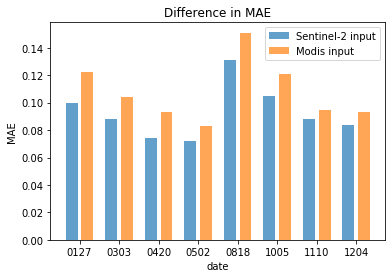

In [98]:
date_str = ["0127","0303","0420","0502","0818","1005","1110","1204"]
date_num = np.array(list(range(len(date_str))))
sen_mae = [0.100,0.088,0.074,0.072,0.131,0.105,0.088,0.084]
mod_mae = [0.122,0.104,0.093,0.083,0.151,0.121,0.095,0.093]

plt.bar(date_num-0.2, sen_mae, width=0.3, label="Sentinel-2 input", alpha=0.7)
plt.bar(date_num+0.2, mod_mae, width=0.3, label="Modis input", alpha=0.7)

plt.xticks(date_num, date_str)
plt.title('Difference in MAE')
plt.ylabel('MAE')
plt.xlabel('date')
plt.legend()

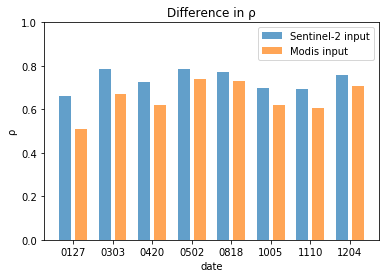

In [92]:
date_str = ["0127","0303","0420","0502","0818","1005","1110","1204"]
date_num = np.array(list(range(len(date_str))))
sen_mae = [0.661,0.786,0.724,0.785,0.773,0.700,0.692,0.759]
mod_mae = [0.510,0.670,0.618,0.738,0.731,0.621,0.608,0.706]

plt.bar(date_num-0.2, sen_mae, width=0.3, label="Sentinel-2 input", alpha=0.7)
plt.bar(date_num+0.2, mod_mae, width=0.3, label="Modis input", alpha=0.7)

plt.xticks(date_num, date_str)
plt.title('Difference in ρ')
plt.ylim(0, 1)
plt.ylabel('ρ')
plt.xlabel('date')
plt.legend()

# Modis時系列

In [409]:
path_list = sorted(glob.glob('../sar_2_ndvi/tsumagoi/time_series/tmp/mod_*.npy'))

loc_list = [[35, 39, 506, 510], [35, 39, 516, 520]]
ndvi_list = [[] for _ in range(len(loc_list))]

for i,loc in enumerate(loc_list):
    date_list = []
    for path in path_list:
        img = np.load(path)
        img_ndvi = cal_ndvi(img[0], img[1])

        date_str = path[-9:-5]
        date = datetime.datetime.strptime('2020'+date_str, '%Y%m%d')
        date_list.append(date)

        ndvi_list[i].append(np.mean(img_ndvi[loc[0]:loc[1], loc[2]:loc[3]]))

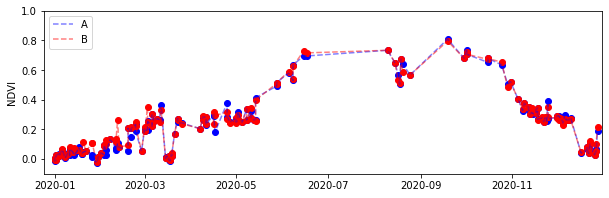

In [410]:
plt.figure(figsize=(10,3))
for ndvi, c, label in zip(ndvi_list, ['blue', 'red'], ['A', 'B']):
    plt.scatter(date_list, ndvi, color=c)
    plt.plot(date_list, ndvi, color=c, label=label, linestyle='--', alpha=0.5)
    
plt.xlim(datetime.datetime(2019,12,25), datetime.datetime(2020,12,31))    
plt.ylim(-0.1,1)
plt.ylabel('NDVI')
plt.legend(loc='upper left')

In [411]:
start_dates = [datetime.datetime(2020,1,3), datetime.datetime(2020,1,10)]
date_list_ = []

for i in range(31):
    for start_date in start_dates:
        date_list_.append(start_date + datetime.timedelta(days=12*i))

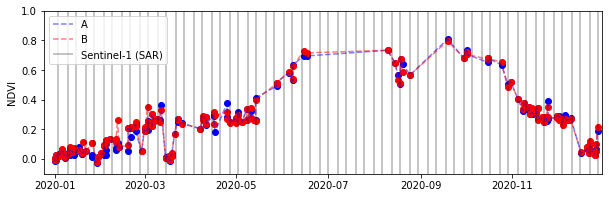

In [412]:
plt.figure(figsize=(10,3))
for ndvi, c, label in zip(ndvi_list, ['blue', 'red'], ['A', 'B']):
    plt.scatter(date_list, ndvi, color=c)
    plt.plot(date_list, ndvi, color=c, label=label, linestyle='--', alpha=0.5)
    
for i,date in enumerate(date_list_):
    if i == 0:
        plt.vlines(date, ymin=-0.1, ymax=1, alpha=0.3, label='Sentinel-1 (SAR)')
    else:
        plt.vlines(date, ymin=-0.1, ymax=1, alpha=0.3)
    
plt.xlim(datetime.datetime(2019,12,25), datetime.datetime(2020,12,31))    
plt.ylim(-0.1,1)
plt.ylabel('NDVI')
plt.legend(loc='upper left')

# Evaluation

Text(0, 0.5, 'Mean Absolute Error')

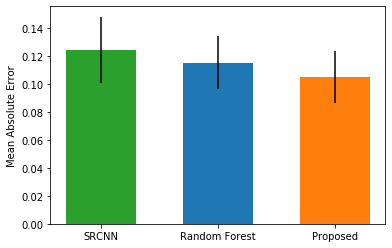

In [414]:
mae_list = [0.12471263,0.1153386652756658,0.10493853545640033] # SRCNN, Linear, Proposed
mae_std_list = [0.02367075,0.0189067772531882,0.01859158712781106]
modis_error = 0.06

plt.bar(['SRCNN', 'Random Forest', 'Proposed'], mae_list, yerr=mae_std_list, color=['C2', 'C0', 'C1'], width=0.6)

plt.ylabel('Mean Absolute Error')

Text(0, 0.5, 'Mean Absolute Error')

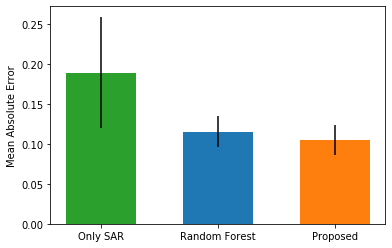

In [432]:
mae_list = [0.18910974,0.1153386652756658,0.10493853545640033] # OnlySAR, Linear, Proposed
mae_std_list = [0.06988768,0.0189067772531882,0.01859158712781106]
modis_error = 0.06

plt.bar(['Only SAR', 'Random Forest', 'Proposed'], mae_list, yerr=mae_std_list, color=['C2', 'C0', 'C1'], width=0.6)

plt.ylabel('Mean Absolute Error')